# Analyse des bombardements dans la presse durant la seconde partie de la seconde guerre mondiale (1942-1945)

Notre travail final présente l'analyse d'un sous corpus portant sur sur les **bombardements dans la presse belge** durant la seconde partie de la deuxieme guerre mondiale  **1942 et 1945**. L'objectif est d'appliquer l'ensemble des connaissances acquises lors des travaux precedents

## Imports

In [48]:
import os
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from collections import defaultdict

import spacy
import pandas as pd

from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

from gensim.models import Word2Vec

from sklearn.manifold import TSNE
import numpy as np

import nltk
from nltk.tokenize import word_tokenize



In [7]:
from pathlib import Path 

data_dir = Path("../data/camille_bombardement")

data_dir


WindowsPath('../data/camille_bombardement')

Verification et comptage des fichiers

In [8]:
# On verifie si le dossier existe
print("Dossier trouvé:", data_dir.exists())

# On récupère tous les fichiers .txt
txt_files = sorted(list(data_dir.glob("*.txt")))

# On affiche le nombre de fichiers présent
print("Nombre de fichier TXT trouvé:", len(txt_files))

# On affiche quelques un
txt_files[:5]

Dossier trouvé: True
Nombre de fichier TXT trouvé: 884


[WindowsPath('../data/camille_bombardement/KB_JB838_1942-01-02_01-00003.txt'),
 WindowsPath('../data/camille_bombardement/KB_JB838_1942-01-05_01-00003.txt'),
 WindowsPath('../data/camille_bombardement/KB_JB838_1942-01-07_01-00003.txt'),
 WindowsPath('../data/camille_bombardement/KB_JB838_1942-01-08_01-00002.txt'),
 WindowsPath('../data/camille_bombardement/KB_JB838_1942-01-08_01-00003.txt')]

Extraction de l'année dans les noms des fichiers

In [9]:
annees = []

pattern = re.compile(r"(18|19|20)\d{2}")

for f in txt_files:
    m = pattern.search(f.name)
    if m:
        year = int(m.group(0))

        if 1800 <= year <= 2100:
            annees.append(year)
        else:
            print("Pas d'année trouvée dans:", f.name)
        
len(annees), annees[:10]

(884, [1942, 1942, 1942, 1942, 1942, 1942, 1942, 1942, 1942, 1942])

Comptage du nombre de fichiers par an

In [10]:
compte_par_annee = Counter(annees)

for annee in sorted(compte_par_annee):
    print(annee, ":", compte_par_annee[annee])

1942 : 176
1943 : 184
1944 : 219
1945 : 305


## Chargement des textes

Lecture des fichiers

In [11]:
def lire_texte(path):
    for enc in ("utf-8", "latin-1", "cp1252"):
        try:
            with open(path, "r", encoding=enc, errors="ignore") as f:
                return f.read()
        except Exception:
            continue
        print("Impossible de lire:", path)
        return ""


Construction de la liste de document

In [12]:
docs = []

print("Nombre de chemins txt:", len(txt_files))
print("Nombre d'années:", len(annees))

for path, year in zip(txt_files, annees):
    texte = lire_texte(path)
    docs.append({
        "fichier": path.name,
        "annee": year,
        "texte": texte
    })

print("Nombre de documents chargés:", len(docs))

Nombre de chemins txt: 884
Nombre d'années: 884
Nombre de documents chargés: 884


Apercu d'un document 

In [13]:
i=0
doc_exemple = docs[i]

print("Fichier:", doc_exemple["fichier"])
print("Année:", doc_exemple["annee"])
print("Longueur du texte:", len(doc_exemple["texte"]), "caractères")
print("\nExtrait : \n")
print(doc_exemple["texte"][:800])

Fichier: KB_JB838_1942-01-02_01-00003.txt
Année: 1942
Longueur du texte: 46315 caractères

Extrait : 

î ïVENDR. 2 JANV. 1942 * * * La situation nülitaire au début de 1942 Berlin, l* r janvier., . On déclare dons los cercles bien informés de Berlin que les données', initiales du développement militaire,,au cours de l'année qui vient de commencer^réunissent tous les atouts dans les molnsldés'puls- sancesdu Pacte & Trois et ne laissent à l’adversalro que des perspectives qui, en 1918, étalent celles des., puissances centrales. L'année 1941 a fait ressortir les faits fondamentaux suivants'. 1° Sécurité du sud-est do TEuropo par suite de la victoire allemande dans les Balkans et do l'occupation! de la Crète, qui ont réduit à néant toute initiative sérleuso de l'ennemi 'en Méditerranée orientale.. - ; . 2® Protection do tout' le flanc oriental de l’Europe, contré lo danger menaçant d’une invasio


## Nettoyage du corpus

 fonction de nettoyage

In [14]:
# On nettoie le texte en vue des analyses, on met tout en majuscules, 
# on remplace des sauts de ligne par des espaces,
# on supprime les chiffre et les signes de ponctuation
# on reduit les multiples espaces 

def nettoyer_texte(texte):

    # Minuscules
    t = texte.lower()

    # On remplace les retours à la ligne par des espaces
    t = t.replace("\n", " ")

    # On supprome tout ce qui n'est pas lettre ou espace
    t = re.sub(r"[^a-zàâäéèêëîïôöùûüçœæ\s-]", " ", t)

    # On remplace des tirets par des espaces
    t = t.replace("-", " ")

    # On reduit les espaces multiples
    t = re.sub(r"\s+", " ", t).strip()

    return t

Application du nettoyage à tout les documents du corpus

In [15]:
for d in docs:
    brut = d["texte"]
    d["texte_net"] = nettoyer_texte(brut)

nb_vides = sum(1 for d in docs if not d["texte_net"])
print("Documents vides après nettoyage:", nb_vides)
print("Documents avec texte nettoyé:", len(docs) - nb_vides)

Documents vides après nettoyage: 0
Documents avec texte nettoyé: 884


Apercu Avant/Après nettoyage

In [16]:
i=0
doc_exemple = docs[i]

print("Fichier:", doc_exemple["fichier"])
print("Année:", doc_exemple["annee"])
print("\n--- TEXTE BRUTE (extrait) ---\n")
print(doc_exemple["texte"][:500])
print("\n--- TEXTE NETTOYE (extrait) ---\n")
print(doc_exemple["texte_net"][:500])

Fichier: KB_JB838_1942-01-02_01-00003.txt
Année: 1942

--- TEXTE BRUTE (extrait) ---

î ïVENDR. 2 JANV. 1942 * * * La situation nülitaire au début de 1942 Berlin, l* r janvier., . On déclare dons los cercles bien informés de Berlin que les données', initiales du développement militaire,,au cours de l'année qui vient de commencer^réunissent tous les atouts dans les molnsldés'puls- sancesdu Pacte & Trois et ne laissent à l’adversalro que des perspectives qui, en 1918, étalent celles des., puissances centrales. L'année 1941 a fait ressortir les faits fondamentaux suivants'. 1° Sécur

--- TEXTE NETTOYE (extrait) ---

î ïvendr janv la situation nülitaire au début de berlin l r janvier on déclare dons los cercles bien informés de berlin que les données initiales du développement militaire au cours de l année qui vient de commencer réunissent tous les atouts dans les molnsldés puls sancesdu pacte trois et ne laissent à l adversalro que des perspectives qui en étalent celles des puissances cen

 ## Exploration Lexicale

In [17]:
# Liste manuelle de stopwords français (inspirée de NLTK + mots peu informatifs du corpus)
sw = [
    # articles / pronoms / auxiliaires fréquents
    "le", "la", "les", "un", "une", "des",
    "de", "du", "au", "aux", "et", "en", "dans", "par", "pour", "sur",
    "ce", "cet", "cette", "ces",
    "qui", "que", "quoi", "dont", "où",
    "ne", "pas", "ni",
    "je", "tu", "il", "elle", "on", "nous", "vous", "ils", "elles",
    "me", "te", "se", "moi", "toi", "lui", "leur", "leurs",
    "mon", "ma", "mes", "ton", "ta", "tes",
    "son", "sa", "ses", "notre", "nos", "votre", "vos",
    "y", "là", "ici",
    
    # formes verbales / auxiliaires fréquents
    "être", "avoir", "fait", "faire", "avait", "étaient", "était", "sont", "sera", "seront",
    "avoir", "avait", "avaient", "ai", "as", "a", "avons", "avez", "ont",
    
    # adverbes / mots peu informatifs
    "plus", "très", "bien", "sans", "avec", "comme", "aussi",
    "tous", "toutes", "tout", "toute",
    "déjà", "encore", "toujours", "souvent",
    "ainsi", "donc", "cependant", "pourtant",
    "après", "avant", "pendant", "depuis",
    "moins", "peut", "aucun", "aucune",
    "non", "oui",

    # mots de structure / bruit
    "qu", "c", "d", "l", "m", "n", "s", "t",

    # mots spécifiques au corpus / peu pertinents pour les thèmes
    "grève", "grèves",      # mot de requête → trop fréquent
    "rossel", "dem", "van", "het"
]

# On transforme en set pour accélérer les recherches
sw = set(sw)
len(sw)

121

In [19]:
from nltk.corpus import stopwords

# Stopwords français de base
sw = stopwords.words("french")

# On ajoute quelques mots fréquents de la presse / du corpus
sw += [
    "les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout",
    "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous",
    "celle", "entre", "encore", "toutes", "pendant", "moins", "dire", "cela", "non",
    "faut", "trois", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres",
    "van", "het", "autre", "jusqu", "ville", "rossel", "dem"
]

# On transforme en ensemble pour que les tests "in" soient rapides
sw = set(sw)

print(f"Nombre de stopwords utilisés : {len(sw)}")
list(sorted(list(sw))[:40])


Nombre de stopwords utilisés : 200


['ai',
 'aie',
 'aient',
 'aies',
 'ainsi',
 'ait',
 'après',
 'as',
 'au',
 'aura',
 'aurai',
 'auraient',
 'aurais',
 'aurait',
 'auras',
 'aurez',
 'auriez',
 'aurions',
 'aurons',
 'auront',
 'aussi',
 'autre',
 'autres',
 'aux',
 'avaient',
 'avais',
 'avait',
 'avec',
 'avez',
 'aviez',
 'avions',
 'avoir',
 'avons',
 'ayant',
 'ayante',
 'ayantes',
 'ayants',
 'ayez',
 'ayons',
 'bien']

Construction de la liste de tokens sur le corpus

In [20]:
# On concatene tous les textes nettoyés en une seule grande chaîne
corpus_net = " ".join(d["texte_net"] for d in docs)

tokens = [w for w in corpus_net.split() if w not in sw and len(w) > 2]

print("Nombre total de tokens (après stopwords):", len(tokens))

freq = Counter(tokens)
freq.most_common(100)

Nombre total de tokens (après stopwords): 3515575


[('guerre', 11642),
 ('rue', 10531),
 ('bruxelles', 9172),
 ('général', 6915),
 ('pays', 6218),
 ('leurs', 6109),
 ('cours', 5998),
 ('gouvernement', 5908),
 ('part', 5580),
 ('grand', 5445),
 ('troupes', 5347),
 ('nord', 5195),
 ('lieu', 5126),
 ('grande', 5088),
 ('ans', 4885),
 ('très', 4846),
 ('ministre', 4744),
 ('allemands', 4463),
 ('toute', 4444),
 ('belgique', 4334),
 ('politique', 4313),
 ('temps', 4281),
 ('jour', 4257),
 ('france', 4234),
 ('front', 4179),
 ('quelques', 4166),
 ('allemagne', 4164),
 ('avant', 4066),
 ('vers', 3923),
 ('sud', 3903),
 ('prix', 3839),
 ('armée', 3821),
 ('place', 3710),
 ('point', 3678),
 ('forces', 3646),
 ('heures', 3610),
 ('belge', 3540),
 ('premier', 3515),
 ('soir', 3496),
 ('ceux', 3490),
 ('peu', 3449),
 ('chef', 3444),
 ('berlin', 3436),
 ('président', 3435),
 ('français', 3426),
 ('etats', 3374),
 ('nouvelle', 3325),
 ('plusieurs', 3296),
 ('déjà', 3295),
 ('également', 3259),
 ('allemande', 3243),
 ('devant', 3212),
 ('nouveau', 31

Nuage de mots global

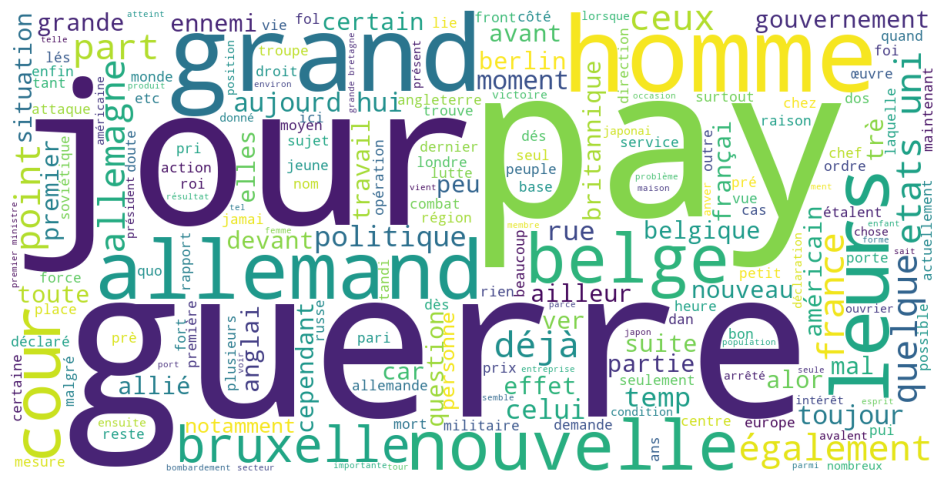

In [21]:
texte_pour_wc = " ".join(tokens)

wc = WordCloud(
    width = 1200,
    height = 600,
    background_color = "white"
).generate(texte_pour_wc)

plt.figure(figsize=(12, 6))
plt.imshow(wc)
plt.axis("off")
plt.show()

amelioration des stopwords

In [22]:
sw.update([
    "est", "été", "mais", "même", "entre",
    "autre", "autres", "sous", "dit", "fut",
    "grand", "prix", "ans", "heures", "cours",
    "lieu", "très", "toute", "leurs", "vers", 
    "très", "celui", "ceux", "tant", "seulement", 
    "certaines", "lorsque", "alors", "bon", "hui",
    "aujourd", "car", "nouvelles", "samedi", "mercredi",
    "lundi", "mardi", "jeudi", "vendredi", "dimanche", 
    "seul", "elles", "toujours", "question", "pris", 
    "avant", "belge", "bruxelles", "pays", "jour", 
    "part", "place", "point", "temps", "quelques", 
    "déjà", "nouvelle", "nouveau", "grand"

])

len(sw)

247

Nouvelle liste de tokens

In [23]:
tokens = [w for w in corpus_net.split() if w not in sw and len(w) > 2]

print("Tokens après amélioration :", len(tokens))
print("\nTop 100 recalculé :")
freq = Counter(tokens)
freq.most_common(100)

Tokens après amélioration : 3354047

Top 100 recalculé :


[('guerre', 11642),
 ('rue', 10531),
 ('général', 6915),
 ('gouvernement', 5908),
 ('troupes', 5347),
 ('nord', 5195),
 ('grande', 5088),
 ('ministre', 4744),
 ('allemands', 4463),
 ('belgique', 4334),
 ('politique', 4313),
 ('france', 4234),
 ('front', 4179),
 ('allemagne', 4164),
 ('sud', 3903),
 ('armée', 3821),
 ('forces', 3646),
 ('premier', 3515),
 ('soir', 3496),
 ('peu', 3449),
 ('chef', 3444),
 ('berlin', 3436),
 ('président', 3435),
 ('français', 3426),
 ('etats', 3374),
 ('plusieurs', 3296),
 ('également', 3259),
 ('allemande', 3243),
 ('devant', 3212),
 ('service', 3175),
 ('londres', 3158),
 ('jours', 3148),
 ('mois', 3141),
 ('situation', 3129),
 ('mort', 3127),
 ('ouest', 3089),
 ('tél', 3082),
 ('ordre', 3076),
 ('ennemi', 2986),
 ('anglais', 2985),
 ('maison', 2950),
 ('hommes', 2949),
 ('juin', 2945),
 ('etat', 2943),
 ('travail', 2942),
 ('américains', 2937),
 ('unis', 2911),
 ('partie', 2882),
 ('vue', 2808),
 ('mal', 2795),
 ('militaire', 2777),
 ('allemand', 2766)

Nuage de mots mis à jour

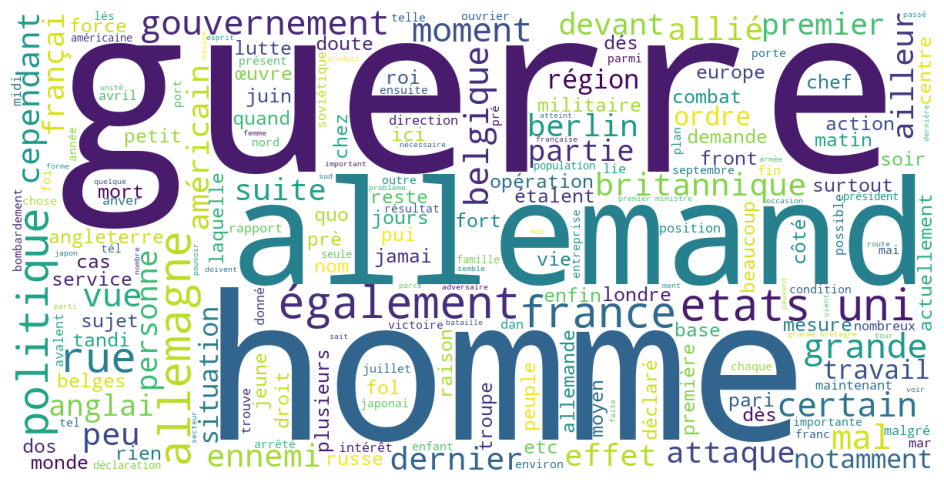

In [24]:
texte_pour_wc = " ".join(tokens)

wc = WordCloud(
    width=1200,
    height=600,
    background_color="white"
).generate(texte_pour_wc)

plt.figure(figsize=(12, 6))
plt.imshow(wc)
plt.axis("off")
plt.show()

## Extraction automatique des mots

Installation et import de YAKE

In [25]:
import yake

Instanciation de l'extracteur de mots clés

In [26]:
kw_extractor = yake.KeywordExtractor(
    lan = "fr",
    n = 2,                                      # on extrait des bigrammes
    top = 50,
)

Extraction des mots clés par année

In [27]:
def yake_annee(annee: int, top_k: int = 50):


    docs_year = [d for d in docs if d.get("annee") == annee]

    print(f"\n--- Annee {annee} ---")
    print(f"Nombre de documents pour {annee} : {len(docs_year)}")

    if not docs_year:
        print("Aucun document trouvé pour cette année.")
        return
    
    # On concatène les textes nettoyes 
    corpus_year = ""
    for d in docs_year:
        txt = d.get("texte_net", "")
        if txt.strip():
            corpus_year += " " + txt
    print(f"Taille du corpus {annee} : {len(corpus_year):,} caractères")

    if not corpus_year.strip():
        print("Corpus vide après concatenation.")
        return
    
    # 3) Extraction YAKE
    keywords = kw_extractor.extract_keywords(corpus_year)
    
    print(f"\nTop {top_k} mots-clés (bigrammes) pour {annee} :")
    for kw, score in keywords[:top_k]:
        print(f" - {kw}  (score = {score:.4f})")

Année 1942

In [28]:
yake_annee(1942)


--- Annee 1942 ---
Nombre de documents pour 1942 : 176
Taille du corpus 1942 : 7,143,077 caractères

Top 50 mots-clés (bigrammes) pour 1942 :
 - etats unis  (score = 0.0000)
 - troupes allemandes  (score = 0.0000)
 - quartier général  (score = 0.0000)
 - forces armées  (score = 0.0000)
 - troupes britanniques  (score = 0.0000)
 - troupes japonaises  (score = 0.0000)
 - combat allemands  (score = 0.0000)
 - informations britannique  (score = 0.0000)
 - avions ennemis  (score = 0.0000)
 - armée allemande  (score = 0.0000)
 - avions britanniques  (score = 0.0000)
 - gouvernement français  (score = 0.0000)
 - haut commandement  (score = 0.0000)
 - gouvernement britannique  (score = 0.0000)
 - porte avions  (score = 0.0000)
 - forces japonaises  (score = 0.0000)
 - guerre britannique  (score = 0.0000)
 - peuple allemand  (score = 0.0000)
 - troupes américaines  (score = 0.0000)
 - forces britanniques  (score = 0.0000)
 - avions anglais  (score = 0.0000)
 - communiqué allemand  (score = 0.0

Annee 1943

In [82]:
yake_annee(1943)


--- Annee 1943 ---
Nombre de documents pour 1943 : 184
Taille du corpus 1943 : 8,711,140 caractères

Top 50 mots-clés (bigrammes) pour 1943 :
 - etats unis  (score = 0.0000)
 - troupes allemandes  (score = 0.0000)
 - anglo américains  (score = 0.0000)
 - mod argent  (score = 0.0000)
 - part berlin  (score = 0.0000)
 - guerre mais  (score = 0.0000)
 - quartier général  (score = 0.0000)
 - grand nombre  (score = 0.0000)
 - grand bruxelles  (score = 0.0000)
 - faire part  (score = 0.0000)
 - derniers jours  (score = 0.0000)
 - forces armées  (score = 0.0000)
 - grand prix  (score = 0.0000)
 - milieux politiques  (score = 0.0000)
 - grande partie  (score = 0.0000)
 - armée allemande  (score = 0.0000)
 - milieux militaires  (score = 0.0000)
 - peuple allemand  (score = 0.0000)
 - bruxelles rue  (score = 0.0000)
 - combat allemands  (score = 0.0000)
 - avions ennemis  (score = 0.0000)
 - communiqué allemand  (score = 0.0000)
 - forces allemandes  (score = 0.0000)
 - militaire allemande  (sc

Annee 1944

In [83]:
yake_annee(1944)


--- Annee 1944 ---
Nombre de documents pour 1944 : 219
Taille du corpus 1944 : 9,611,888 caractères

Top 50 mots-clés (bigrammes) pour 1944 :
 - plus grande  (score = 0.0000)
 - troupes allemandes  (score = 0.0000)
 - sud ouest  (score = 0.0000)
 - anglo américains  (score = 0.0000)
 - nord ouest  (score = 0.0000)
 - bruxelles rue  (score = 0.0000)
 - armée allemande  (score = 0.0000)
 - faire part  (score = 0.0000)
 - plus haut  (score = 0.0000)
 - armées allemandes  (score = 0.0000)
 - etats unis  (score = 0.0000)
 - plus tard  (score = 0.0000)
 - plus large  (score = 0.0000)
 - autant plus  (score = 0.0000)
 - grand prix  (score = 0.0000)
 - jours plus  (score = 0.0000)
 - rue van  (score = 0.0000)
 - grand nombre  (score = 0.0000)
 - derniers jours  (score = 0.0000)
 - plus  (score = 0.0000)
 - grand bruxelles  (score = 0.0000)
 - forces armées  (score = 0.0000)
 - louvain bruxelles  (score = 0.0000)
 - grande partie  (score = 0.0000)
 - commandement allemand  (score = 0.0000)
 - 

Annee 1945

In [84]:
yake_annee(1945)


--- Annee 1945 ---
Nombre de documents pour 1945 : 305
Taille du corpus 1945 : 13,257,717 caractères

Top 50 mots-clés (bigrammes) pour 1945 :
 - bruxelles rue  (score = 0.0000)
 - faire part  (score = 0.0000)
 - etats unis  (score = 0.0000)
 - van acker  (score = 0.0000)
 - rue van  (score = 0.0000)
 - prisonnier politique  (score = 0.0000)
 - rue royale  (score = 0.0000)
 - tient lieu  (score = 0.0000)
 - grand prix  (score = 0.0000)
 - grande bretagne  (score = 0.0000)
 - agence rossel  (score = 0.0000)
 - gouvernement belge  (score = 0.0000)
 - part bruxelles  (score = 0.0000)
 - bruxelles tél  (score = 0.0000)
 - royale bruxelles  (score = 0.0000)
 - guerre bruxelles  (score = 0.0000)
 - armée américaine  (score = 0.0000)
 - paris rue  (score = 0.0000)
 - part rue  (score = 0.0000)
 - grand place  (score = 0.0000)
 - avis tient  (score = 0.0000)
 - radio bruxelles  (score = 0.0000)
 - grand bruxelles  (score = 0.0000)
 - gouvernement britannique  (score = 0.0000)
 - rossel rue  (

## Entités nommées (NER)

Chargement des modèles français

In [29]:
try:
    nlp_ner = spacy.load("fr_core_news_sm")
except OSError:
    print("Modèle *fr_core_news_sm* introuvable.")
    raise
print("Pipeline NER chargé:", nlp_ner.pipe_names)

Pipeline NER chargé: ['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


Verification des années présents

In [30]:
annees = sorted({d.get("annee") for d in docs if d.get("annee") is not None})
print("Années dans le corpus:", annees)

Années dans le corpus: [1942, 1943, 1944, 1945]


Fonction NER pour chaque année

In [31]:
from collections import Counter

def ner_annee(annee: int, top_k: int = 15):
    """
    Extrait les entités nommées (PER, LOC, ORG) pour une année donnée.
    Affiche les top entités par type.
    """
    # Sélection des documents de l'année
    docs_year = [d for d in docs if d.get("annee") == annee]
    
    print(f"\n===== NER pour l'année {annee} =====")
    print(f"Nombre de documents : {len(docs_year)}")
    
    if not docs_year:
        print("Aucun document pour cette année.")
        return
    
    # Préparation des textes (on privilégie le texte brut si disponible)
    texts = []
    for d in docs_year:
        txt = d.get("texte", "") or d.get("texte_net", "")
        if txt and txt.strip():
            texts.append(txt)
    
    if not texts:
        print("ucun texte exploitable après filtrage.")
        return
    
    print(f"Nombre de textes envoyés au NER : {len(texts)}")
    
    # Désactiver tout sauf le NER pour gagner en vitesse/mémoire
    disable_pipes = [p for p in nlp_ner.pipe_names if p != "ner"]
    
    per_counter = Counter()
    loc_counter = Counter()
    org_counter = Counter()
    
    # Traitement en flux avec nlp.pipe (plus efficace que une doc par une doc)
    with nlp_ner.select_pipes(disable=disable_pipes):
        for doc_spacy in nlp_ner.pipe(texts, batch_size=20):
            for ent in doc_spacy.ents:
                label = ent.label_
                text_ent = ent.text.strip()
                if not text_ent:
                    continue
                if label == "PER":
                    per_counter[text_ent] += 1
                elif label == "LOC":
                    loc_counter[text_ent] += 1
                elif label == "ORG":
                    org_counter[text_ent] += 1
    
    # Affichage des résultats
    print("\nTop personnes (PER) :")
    for ent, freq in per_counter.most_common(top_k):
        print(f" - {ent} ({freq})")
        
    print("\nTop lieux (LOC) :")
    for ent, freq in loc_counter.most_common(top_k):
        print(f" - {ent} ({freq})")
        
    print("\nTop organisations (ORG) :")
    for ent, freq in org_counter.most_common(top_k):
        print(f" - {ent} ({freq})")


Appel annee par annee

Annee 1942

In [92]:
ner_annee(1942)


===== NER pour l'année 1942 =====
Nombre de documents : 176
Nombre de textes envoyés au NER : 176

Top personnes (PER) :
 - n’ (2368)
 - M. (222)
 - M. Churchill (212)
 - qu’ (206)
 - Roosevelt (197)
 - M. Laval (154)
 - Churchill (122)
 - Staline (118)
 - Führer (115)
 - jusqu’ (105)
 - Stafford Cripps (105)
 - maréchal Pétain (104)
 - Darlan (102)
 - Laval (93)
 - Maréchal (92)

Top lieux (LOC) :
 - qu’ (1628)
 - Allemagne (852)
 - s’ (769)
 - A (752)
 - Etats-Unis (673)
 - Berlin (664)
 - Angleterre (655)
 - Europe (574)
 - Etat (531)
 - la France (510)
 - Japonais (485)
 - Londres (449)
 - Inde (408)
 - Bruxelles (385)
 - Birmanie (369)

Top organisations (ORG) :
 - Reich (279)
 - Axe (254)
 - U (161)
 - Conseil (141)
 - qu’ (135)
 - Luftwaffe (117)
 - l’Axe (74)
 - PROVINCE (59)
 - Parlement (57)
 - ministre des Affaires étrangères (55)
 - Légion (49)
 - SOIR (47)
 - Union Soviétique (46)
 - Times (45)
 - Wehrmacht (44)


Annee 1943

In [93]:
ner_annee(1943)


===== NER pour l'année 1943 =====
Nombre de documents : 184
Nombre de textes envoyés au NER : 184

Top personnes (PER) :
 - n’ (1985)
 - M. (316)
 - M (288)
 - Roosevelt (224)
 - Staline (180)
 - Giraud (178)
 - Lie (168)
 - qu’ (158)
 - Enf (125)
 - de Gaulle (119)
 - Jeudi (115)
 - Duce (113)
 - Janvier (108)
 - Churchill (108)
 - H (104)

Top lieux (LOC) :
 - A (3142)
 - qu’ (1225)
 - Bruxelles (755)
 - I (679)
 - fr (645)
 - Berlin (645)
 - s’ (630)
 - Allemagne (617)
 - Europe (549)
 - Etat (450)
 - Etats-Unis (420)
 - Londres (379)
 - Angleterre (352)
 - Rome (319)
 - L’ (311)

Top organisations (ORG) :
 - U (377)
 - Axe (262)
 - Reich (176)
 - qu’ (103)
 - Conseil (86)
 - rie (76)
 - Comité (74)
 - PARISIENS (70)
 - CHEQUES (68)
 - Union Soviétique (68)
 - l’Axe (67)
 - Immédiatement (67)
 - MUTUEL (65)
 - MM. (64)
 - Luftwaffe (56)


Annee 1944

In [94]:
ner_annee(1944)


===== NER pour l'année 1944 =====
Nombre de documents : 219
Nombre de textes envoyés au NER : 219

Top personnes (PER) :
 - n’ (2052)
 - M. (369)
 - Lie (325)
 - M (270)
 - Jeudi (177)
 - qu’ (163)
 - Monsieur (150)
 - Enf (144)
 - Idem (139)
 - V (127)
 - Rossel (126)
 - H (117)
 - M. Churchill (105)
 - Ag (104)
 - S’ (102)

Top lieux (LOC) :
 - A (3230)
 - qu’ (1339)
 - I (1205)
 - Bruxelles (1138)
 - s’ (754)
 - Londres (745)
 - fr (740)
 - Allemagne (649)
 - Berlin (623)
 - Angleterre (535)
 - Allemands (504)
 - Belgique (483)
 - P (410)
 - Paris (394)
 - Américains (389)

Top organisations (ORG) :
 - U (515)
 - Reich (200)
 - Conseil (116)
 - Ec (103)
 - SOIR (101)
 - gr (101)
 - qu’ (98)
 - Immédiatement (91)
 - rie (83)
 - Reuter (73)
 - PARISIENS (70)
 - CHEQUES (70)
 - Parlement (65)
 - MUTUEL (59)
 - AR (59)


Annee 1945

In [95]:
ner_annee(1945)


===== NER pour l'année 1945 =====
Nombre de documents : 305
Nombre de textes envoyés au NER : 305

Top personnes (PER) :
 - n’ (3654)
 - Roi (1174)
 - M. (891)
 - Hitler (558)
 - qu’ (452)
 - Monsieur (444)
 - M (349)
 - M. Van Acker (286)
 - Pétain (266)
 - Hardy (246)
 - général de Gaulle (241)
 - Reuter (235)
 - Président (229)
 - Ett (216)
 - Truman (208)

Top lieux (LOC) :
 - Bruxelles (2794)
 - qu’ (2520)
 - Belgique (1527)
 - Allemagne (1520)
 - A (1423)
 - s’ (1248)
 - fr (1125)
 - Allemands (1048)
 - L’ (1005)
 - Londres (847)
 - Etat (775)
 - Anvers (710)
 - Brux (705)
 - Etats-Unis (657)
 - Berlin (631)

Top organisations (ORG) :
 - Conseil (530)
 - Chambre (301)
 - Gestapo (281)
 - Reuter (258)
 - Parlement (204)
 - U (190)
 - Sénat (169)
 - qu’ (162)
 - Radio (161)
 - Reich (154)
 - SS (143)
 - MONSIEUR (132)
 - NOVA (121)
 - LUTETIA (121)
 - ministre des Affaires étrangères (116)


## Analyse des sentiments

Creation de l'analyseur francophone

In [32]:
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

print("Analyseur de sentiment FR initialisé")

Analyseur de sentiment FR initialisé


Fonction d'analyse de sentiment

In [33]:
def sentiment_texte(txt: str):

# Calcule la polarité et la subjectivité d'un texte en français 
# en utilisant TextBlobFR.

    if not txt or not txt.strip():
        return None, None
    
    extrait = txt    # [:3000]
    blob = tb(extrait)
    pol, subj = blob.sentiment
    return pol, subj

Calcul du sentiment pour chaque document

In [34]:
# Dictionnaire : année -> liste de (polarité, subjectivité)
sentiments_par_annee = defaultdict(list)

nb_docs_sentiment = 0

for d in docs:
    annee = d.get("annee")
    if annee is None:
        continue  # au cas où

    # On privilégie le texte nettoyé s'il existe
    txt = d.get("texte_net") or d.get("texte") or ""
    if not txt.strip():
        continue

    pol, subj = sentiment_texte(txt)
    if pol is None:
        continue

    sentiments_par_annee[annee].append((pol, subj))
    nb_docs_sentiment += 1

print(f"Nombre de documents avec sentiment calculé : {nb_docs_sentiment}")
print("Années trouvées :", sorted(sentiments_par_annee.keys()))


Nombre de documents avec sentiment calculé : 884
Années trouvées : [1942, 1943, 1944, 1945]


Calcul des moyennes de la polarité et subjecticité pour chqaue année

In [35]:
resume_sentiment = []

for annee, valeurs in sentiments_par_annee.items():
    if len(valeurs) == 0:
        continue

    polarites = [p for (p, s) in valeurs]
    subjectivites = [s for (p, s) in valeurs]

    resume_sentiment.append({
        "annee": annee,
        "nb_docs": len(valeurs),
        "polarite_moyenne": sum(polarites) / len(polarites),
        "subjectivite_moyenne": sum(subjectivites) / len(subjectivites),
    })

df_sent = pd.DataFrame(resume_sentiment).sort_values("annee")
df_sent

,annee,nb_docs,polarite_moyenne,subjectivite_moyenne
0,1942,176,0.052813,0.218763
1,1943,184,0.071006,0.231892
2,1944,219,0.063282,0.239477
3,1945,305,0.077079,0.220664


Visualisation des tendances (polarité et subjectivité)

courbe de polarité

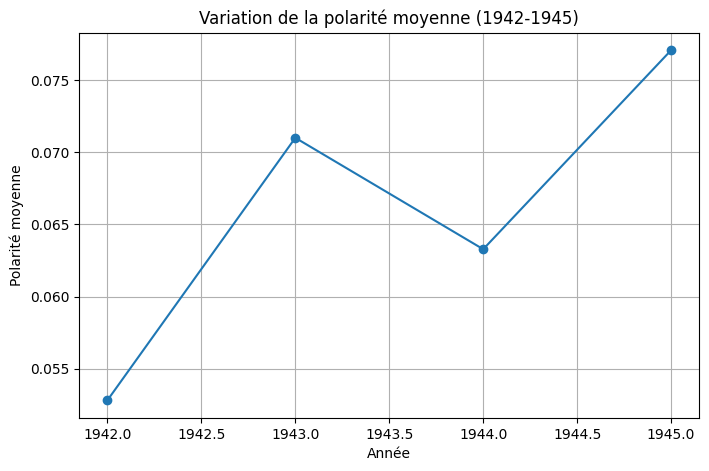

In [36]:
plt.figure(figsize=(8,5))
plt.plot(df_sent["annee"], df_sent["polarite_moyenne"], marker="o")
plt.title("Variation de la polarité moyenne (1942-1945)")
plt.xlabel("Année")
plt.ylabel("Polarité moyenne")
plt.grid(True)
plt.show()

Courbe de la subjectivité

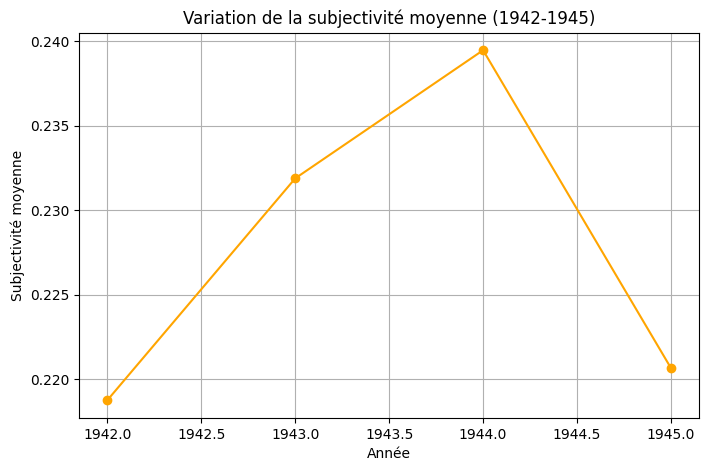

In [37]:
plt.figure(figsize=(8,5))
plt.plot(df_sent["annee"], df_sent["subjectivite_moyenne"], marker="o", color="orange")
plt.title("Variation de la subjectivité moyenne (1942-1945)")
plt.xlabel("Année")
plt.ylabel("Subjectivité moyenne")
plt.grid(True)
plt.show()

## Word2Vec

Preparation des phrases par année

In [38]:
ANNEES_W2V = [1942, 1943, 1944, 1945]

# Dictionnaire : année -> liste de phrases (chaque phrase = liste de tokens)
sentences_par_annee = {a: [] for a in ANNEES_W2V}

for d in docs:
    annee = d.get("annee")
    if annee not in sentences_par_annee:
        continue
    
    # On prend le texte nettoyé en priorité
    txt = d.get("texte_net") or d.get("texte") or ""
    txt = txt.strip()
    if not txt:
        continue

    # Tokenisation très simple (le texte est déjà nettoyé)
    tokens = [w for w in txt.split() if len(w) > 2]
    if tokens:
        sentences_par_annee[annee].append(tokens)

# Petit résumé pour vérifier
for annee, sents in sentences_par_annee.items():
    print(f"Année {annee} : {len(sents)} documents tokenisés")
    if sents:
        print("  Exemple de tokens :", sents[0][:20])


Année 1942 : 176 documents tokenisés
  Exemple de tokens : ['ïvendr', 'janv', 'situation', 'nülitaire', 'début', 'berlin', 'janvier', 'déclare', 'dons', 'los', 'cercles', 'bien', 'informés', 'berlin', 'que', 'les', 'données', 'initiales', 'développement', 'militaire']
Année 1943 : 184 documents tokenisés
  Exemple de tokens : ['humanisme', 'scientifique', 'comédie', 'des', 'éléments', 'jtn', 'vérité', 'vous', 'dis', 'ijcl', 'charmant', 'appartient', 'aux', 'petits', 'histoire', 'knmaralzamnn', 'avec', 'princesse', 'floqdour', 'plut']
Année 1944 : 219 documents tokenisés
  Exemple de tokens : ['venlose', 'ojü', 'vende', 'pas', 'énonces', 'plfflchéfes', 'services', 'behimrp', 'zlmmeralro', 'berlin', 'tél', 'annee', 'services', 'pajus', 'ens', 'bout', 'malesherbes', 'paris', 'tél', 'anjou']
Année 1945 : 305 documents tokenisés
  Exemple de tokens : ['est', 'résultat', 'pression', 'exeroée', 'par', 'ire', 'armées', 'américaines', 'vers', 'des', 'réglons', 'vitales', 'allemagne', 'était', '

Entraînement Word2Vec par année

In [52]:
w2v_par_annee = {}

for annee, sents in sentences_par_annee.items():
    if not sents:
        print(f"Année {annee} : aucun texte, modèle non entraîné.")
        continue
    
    print(f"Entraînement Word2Vec pour l'année {annee} sur {len(sents)} documents...")
    model = Word2Vec(
        sentences=sents,
        vector_size=100,   # taille des vecteurs
        window=5,          # fenêtre de contexte
        min_count=5,       # ignore les mots très rares
        workers=4,         # threads (si ta machine le permet)
        sg=0,              # 0 = CBOW, 1 = Skip-gram (on peut changer si tu veux)
        epochs=10
    )
    w2v_par_annee[annee] = model
    print(f"  -> vocabulaire: {len(model.wv)} mots\n")


Entraînement Word2Vec pour l'année 1942 sur 176 documents...
  -> vocabulaire: 14316 mots

Entraînement Word2Vec pour l'année 1943 sur 184 documents...
  -> vocabulaire: 18645 mots

Entraînement Word2Vec pour l'année 1944 sur 219 documents...
  -> vocabulaire: 19796 mots

Entraînement Word2Vec pour l'année 1945 sur 305 documents...
  -> vocabulaire: 24544 mots



Affichage des mots les plus proches

In [53]:
def mots_proches(annee: int, mot: str, topn: int = 10):
    """
    Affiche les mots les plus similaires à `mot`
    pour l'année donnée, en utilisant le modèle Word2Vec correspondant.
    """
    if annee not in w2v_par_annee:
        print(f"Aucun modèle Word2Vec pour l'année {annee}.")
        return
    
    model = w2v_par_annee[annee]
    
    if mot not in model.wv:
        print(f"Le mot « {mot} » n'est pas dans le vocabulaire de {annee}.")
        # Astuce : on peut proposer quelques mots proches de l’orthographe…
        proches = [w for w in model.wv.index_to_key if w.startswith(mot[:3])][:10]
        if proches:
            print("Mots approchants dans le vocabulaire :", ", ".join(proches))
        return
    
    print(f"\nMots proches de « {mot} » en {annee} :")
    for w, score in model.wv.most_similar(mot, topn=topn):
        print(f"  - {w:15s} (sim = {score:.3f})")


Choix et Test des mots thematiques

In [54]:
mots_proches(1942, "guerre")
mots_proches(1943, "bombardement")
mots_proches(1944, "allemands")
mots_proches(1945, "bruxelles")



Mots proches de « guerre » en 1942 :
  - hostilités      (sim = 0.588)
  - conflagration   (sim = 0.477)
  - bataille        (sim = 0.464)
  - campagne        (sim = 0.462)
  - victoire        (sim = 0.461)
  - défaite         (sim = 0.457)
  - conflit         (sim = 0.449)
  - armement        (sim = 0.448)
  - marchande       (sim = 0.430)
  - paix            (sim = 0.426)

Mots proches de « bombardement » en 1943 :
  - aérien          (sim = 0.818)
  - raid            (sim = 0.812)
  - bombardiers     (sim = 0.752)
  - morts           (sim = 0.718)
  - banlieue        (sim = 0.707)
  - victimes        (sim = 0.697)
  - bombardée       (sim = 0.688)
  - avions          (sim = 0.687)
  - hier            (sim = 0.679)
  - abattus         (sim = 0.673)

Mots proches de « allemands » en 1944 :
  - britanniques    (sim = 0.833)
  - japonais        (sim = 0.792)
  - canadiens       (sim = 0.782)
  - alliés          (sim = 0.767)
  - soviets         (sim = 0.765)
  - américains      (sim = 

Comparaison des mots sur plusieurs années

In [55]:
def comparer_mot_sur_annees(mot: str, annees=(1942, 1943, 1944, 1945), topn=8):
    """
    Affiche les mots les plus similaires à `mot` pour plusieurs années.
    Permet de voir comment le contexte évolue.
    """
    print(f"\n=== Comparaison du mot « {mot} » sur plusieurs années ===")
    for annee in annees:
        print(f"\n--- {annee} ---")
        model = w2v_par_annee.get(annee)
        if model is None:
            print("  Pas de modèle pour cette année.")
            continue
        if mot not in model.wv:
            print(f"  Le mot « {mot} » n'est pas dans le vocabulaire de {annee}.")
            continue
        for w, score in model.wv.most_similar(mot, topn=topn):
            print(f"  {w:15s} (sim = {score:.3f})")

Mots à tester

In [56]:
comparer_mot_sur_annees("guerre")
comparer_mot_sur_annees("bombardement")


=== Comparaison du mot « guerre » sur plusieurs années ===

--- 1942 ---
  hostilités      (sim = 0.588)
  conflagration   (sim = 0.477)
  bataille        (sim = 0.464)
  campagne        (sim = 0.462)
  victoire        (sim = 0.461)
  défaite         (sim = 0.457)
  conflit         (sim = 0.449)
  armement        (sim = 0.448)

--- 1943 ---
  hostilités      (sim = 0.550)
  navigation      (sim = 0.503)
  guerro          (sim = 0.503)
  occupation      (sim = 0.489)
  période         (sim = 0.484)
  paix            (sim = 0.484)
  guorre          (sim = 0.482)
  organisation    (sim = 0.460)

--- 1944 ---
  guorro          (sim = 0.558)
  guerro          (sim = 0.550)
  hostilités      (sim = 0.537)
  occupation      (sim = 0.511)
  libération      (sim = 0.494)
  marchande       (sim = 0.485)
  suprématie      (sim = 0.477)
  destruction     (sim = 0.463)

--- 1945 ---
  occupation      (sim = 0.506)
  hostilités      (sim = 0.505)
  période         (sim = 0.481)
  querre          (s

Visualisation Word2Vec en 2D (TSNE)

Fonction utilitaire

In [57]:
def plot_w2v_annee(annee, mots_cibles, n_voisins=10, perplexity=20):
    
        # Visualise en 2D (TSNE) les mots cibles + leurs voisins
        # pour une année donnée.
        # - annee : 1942, 1943, ...
        # - mots_cibles : liste de mots, ex. ["guerre", "bombardement"]
        # - n_voisins : nombre de voisins proches par mot cible

    if annee not in models_w2v:
        print(f"Pas de modèle Word2Vec pour l'année {annee}.")
        return
    
    model = models_w2v[annee]
    vocab = set(model.wv.index_to_key)

    # On collecte les mots et leurs vecteurs
    mots = []
    vecteurs = []
    couleurs = []   # 0 = mot cible, 1,2,... = voisins
    etiquettes = []

    for i, mot in enumerate(mots_cibles):
        if mot not in vocab:
            print(f"⚠️ Mot '{mot}' introuvable dans le vocabulaire de {annee}")
            continue
        
        # mot cible
        mots.append(mot)
        vecteurs.append(model.wv[mot])
        couleurs.append(i)  # une couleur par mot cible
        etiquettes.append(mot + " (cible)")
        
        # voisins les plus proches
        for voisin, sim in model.wv.most_similar(mot, topn=n_voisins):
            if voisin not in vocab:
                continue
            mots.append(voisin)
            vecteurs.append(model.wv[voisin])
            couleurs.append(i)  # même couleur que son mot cible
            etiquettes.append(voisin)

    if not vecteurs:
        print("Aucun vecteur à projeter.")
        return

    X = np.vstack(vecteurs)

    # Projection TSNE en 2D
    tsne = TSNE(
        n_components=2,
        perplexity=min(perplexity, max(5, len(mots) - 1)),
        n_iter=1000,
        random_state=42
    )
    X_2d = tsne.fit_transform(X)

    plt.figure(figsize=(10, 8))
    # Nuage de points
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=couleurs, alpha=0.7)

    # Étiquettes
    for (x, y, label) in zip(X_2d[:, 0], X_2d[:, 1], etiquettes):
        plt.text(x + 0.01, y + 0.01, label, fontsize=8)

    plt.title(f"Projection Word2Vec (TSNE) – année {annee}")
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [58]:
# Construire un dictionnaire année -> liste de documents
docs_par_annee = {}

for d in docs:
    annee = d.get("annee")
    if annee is None:
        continue
    if annee not in docs_par_annee:
        docs_par_annee[annee] = []
    docs_par_annee[annee].append(d)

print("Années trouvées :", list(docs_par_annee.keys()))
for a in docs_par_annee:
    print(f"Année {a} : {len(docs_par_annee[a])} documents")


Années trouvées : [1942, 1943, 1944, 1945]
Année 1942 : 176 documents
Année 1943 : 184 documents
Année 1944 : 219 documents
Année 1945 : 305 documents


In [68]:
import re

def tokens_pour_wordcloud(txt: str):

    if not txt:
        return []

    # 1) on extrait les mots (lettres + accents + apostrophes éventuelles)
    candidats = re.findall(r"[a-zA-ZÀÂÇÉÈÊËÎÏÔÛÙÜŸÑÆŒàâçéèêëîïôûùüÿñæœ'-]+", txt)

    tokens = []
    for w in candidats:
        w = w.lower()

        # 2) longueur minimale
        if len(w) <= 3:
            continue

        # 3) on enlève les stopwords
        if w in sw:
            continue

        # 4) on enlève les trucs contenant autre chose que lettres/apostrophes
        if not re.match(r"^[a-zàâçéèêëîïôûùüÿçæœ'-]+$", w):
            continue

        tokens.append(w)

    return tokens


In [72]:
tokens_par_annee_wc = {}

for annee, ds in docs_par_annee.items():
    tokens_une_annee = []
    for d in ds:
        txt = d["texte_net"] or d["texte"] or ""
        tokens_une_annee.extend(tokens_pour_wordcloud(txt))
    tokens_par_annee_wc[annee] = tokens_une_annee
    print(f"Année {annee} : {len(tokens_une_annee)} tokens pour WordCloud")

Année 1942 : 555333 tokens pour WordCloud
Année 1943 : 696112 tokens pour WordCloud
Année 1944 : 768095 tokens pour WordCloud
Année 1945 : 1080958 tokens pour WordCloud


Nuage de mots par année

In [76]:
def wordcloud_annee(annee, max_words=100):
    if annee not in tokens_par_annee_wc:
        print(f"Aucun tokens enregistrés pour l'année {annee}.")
        return

    tokens = tokens_par_annee_wc[annee]
    if not tokens:
        print(f"Aucun token exploitable pour l'année {annee}.")
        return

    texte_annee = " ".join(tokens)

    wc = WordCloud(
        width=900,
        height=450,
        background_color="white",
        max_words=max_words,
        collocations=False
    ).generate(texte_annee)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Nuage de mots – année {annee}")
    plt.show()


Affichage des nuages de points

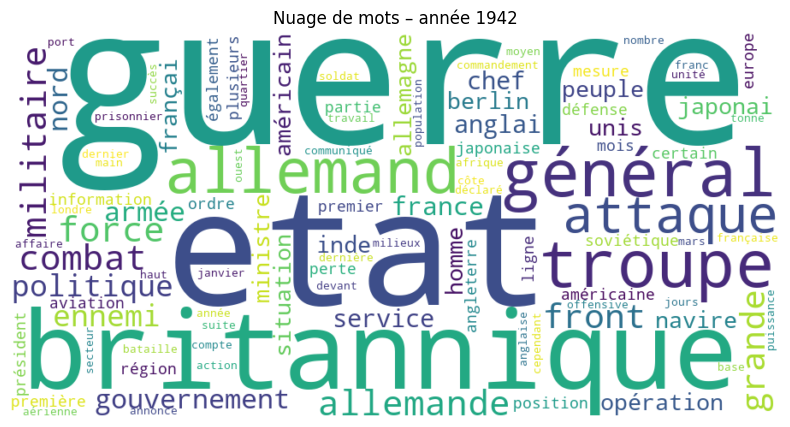

In [77]:
wordcloud_annee(1942)


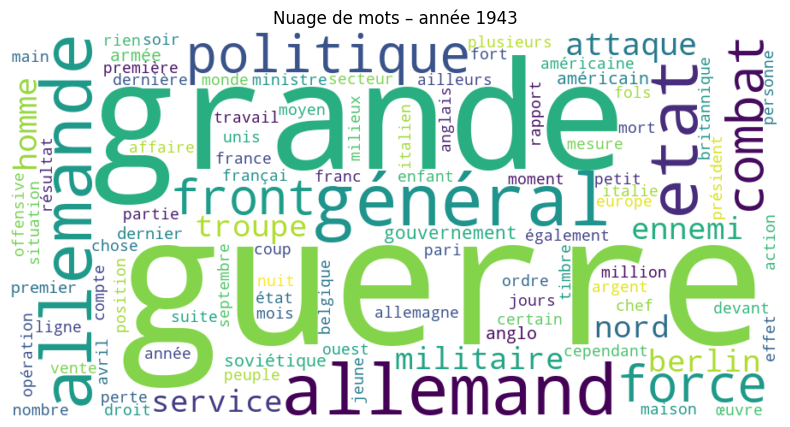

In [78]:
wordcloud_annee(1943)

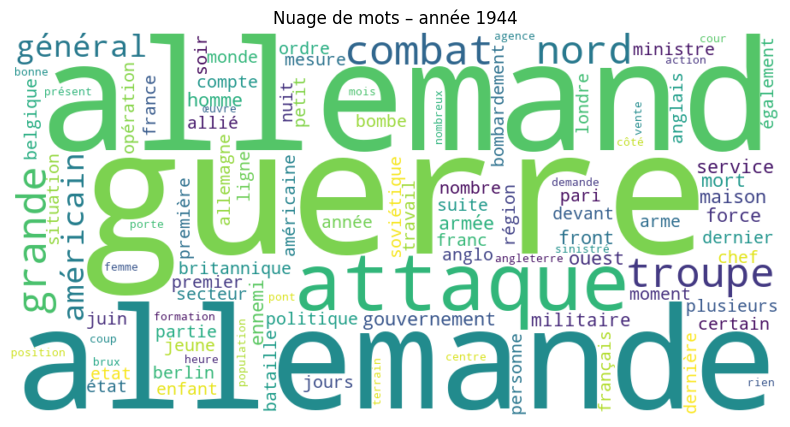

In [79]:
wordcloud_annee(1944)

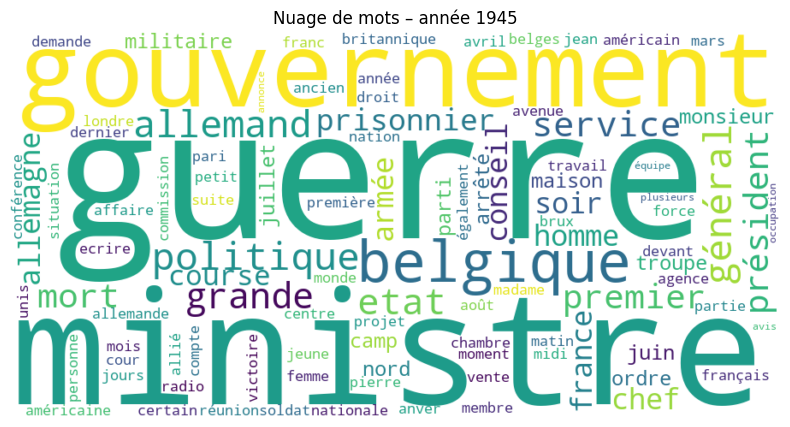

In [80]:
wordcloud_annee(1945)